In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/passive_all.run")

In [6]:
solver = fitter.Fitter(context)

In [7]:
for rhoi in np.logspace(-6, 8, num=57):
    solver.solve(rhoi)
    for i, p in enumerate(solver.problems):
        p.initial_guess = solver.solutions[str(rhoi)][i].x

# Validation

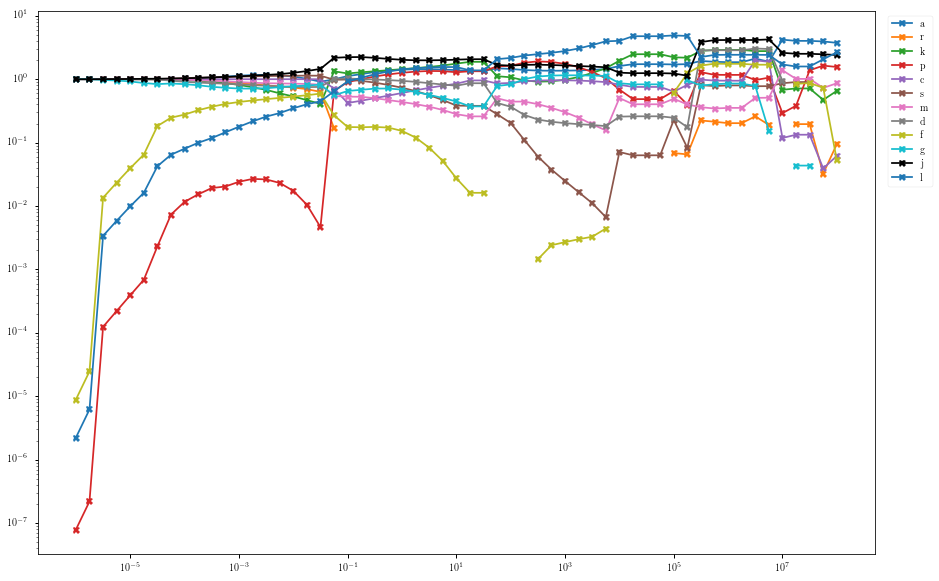

In [8]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("arkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0, 0.5, 'Number')

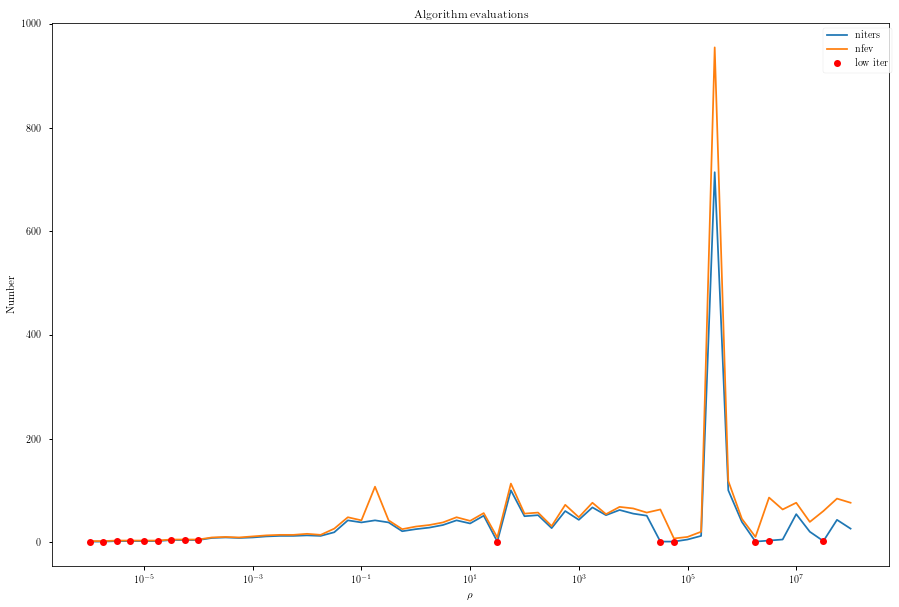

In [9]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [10]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [solver.models[0].ts, *solver.models[0].cs], solver.models[0].xs)
    

par a=1.3632415847922297
par r=0.0
par k=0.9787021611171031
par p=1.746588967876935
par m=0.9610166839952637
par s=0.0247762754770553
par c=0.3014809488854166
par d=0.20259833383251455
par f=0.002696330590120984
par g=1.153363979905161
par j=1.6457387876726055
par l=2.7812193042147135
[[ 0.38842557 -0.24297354  0.17455267]]
[[ 0.69097451  2.15165523 -5.36854444]]


Text(0.5, 0, 'time, t')

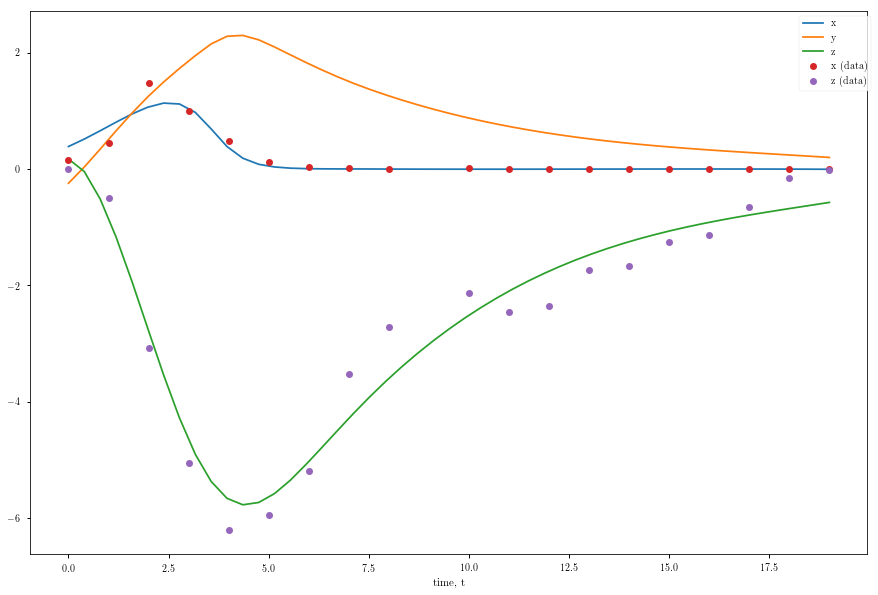

In [89]:
target_rho = 1000.0
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
for param, pval in zip('arkpmscdfgjl??????', solver.solutions[str(target_rho)][0].x):
    print(f"par {param}={pval}")
xs_end = np.array([np.array(i) for i in getx(solver.models[0].observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
print(xs_end[:,9].T)
plt.plot(solver.models[0].observation_times, xs_end.reshape(3, 49).T,
         context.datasets[0]['t'], np.array([list(x) for x in context.datasets[0]['y']]), 'o')
#          context.datasets[0]['t'], context.datasets[0]['x'], 'o',
#          context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

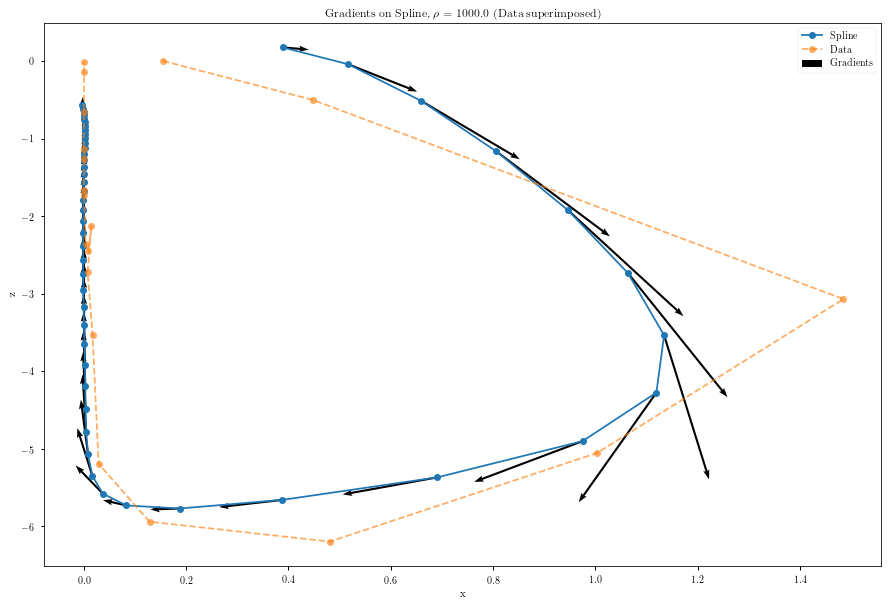

In [49]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(solver.models[0].observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

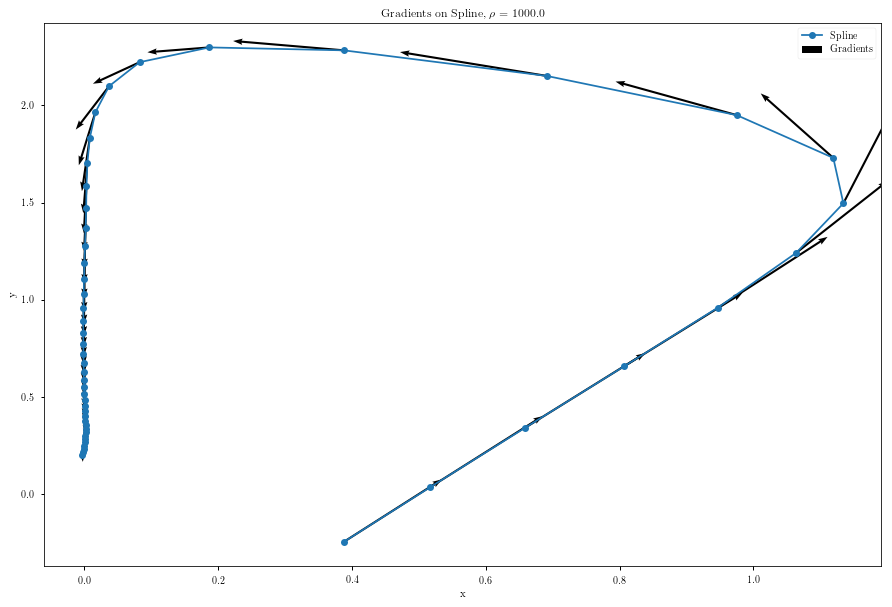

In [50]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

In [15]:
tf_fn = lambda r, v: solver.inner_objectives[0].inner_criterion_fn(solver.models[0].observation_times,
                                                                 *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                                 *v,
                                                                 solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                                 len(context.datasets[0]['t']),
                                                                 *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                                 r)
tf_values = np.array([[r, tf_fn(r, v)] for r, v in zip(rhos, vals)])

In [16]:
oo_fn = lambda r, v: solver.inner_objectives[0]._obj_fn1(solver.models[0].observation_times,
                                                         *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                         *v,
                                                         solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                         len(context.datasets[0]['t']),
                                                         *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                         r)
datafit_values = np.array([[r, oo_fn(r, v)] for r, v in zip(rhos, vals)])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

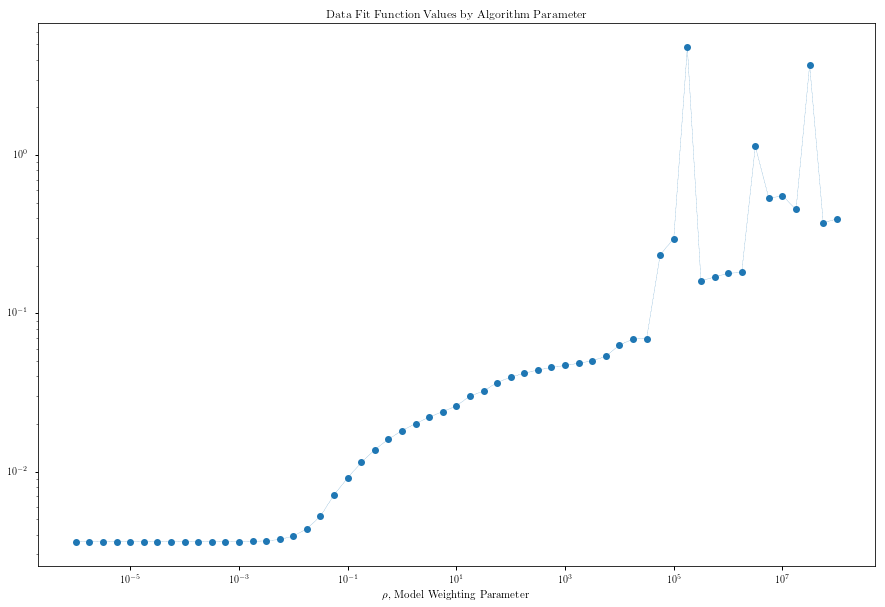

In [17]:
plt.loglog(*datafit_values.T, 'o--', linewidth=0.25)
plt.title("Data Fit Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

In [18]:
dfield_fn = lambda r, v: solver.inner_objectives[0]._obj_fn2(solver.models[0].observation_times,
                                                             *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                             *v,
                                                             solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                             len(context.datasets[0]['t']),
                                                             *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                             r)

dfield_direct = np.array([[r, dfield_fn(r, v)] for r, v in zip(rhos, vals)])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

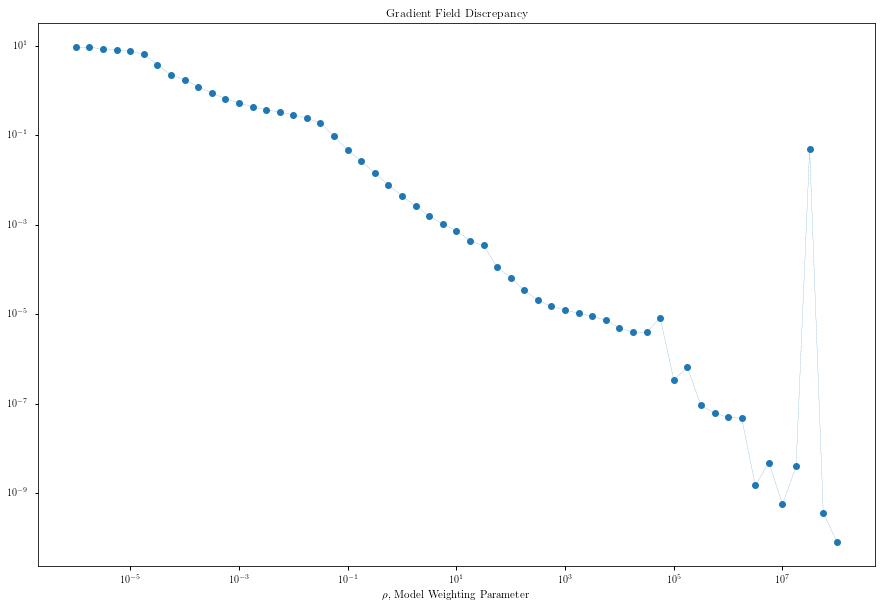

In [19]:
plt.loglog(*dfield_direct.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

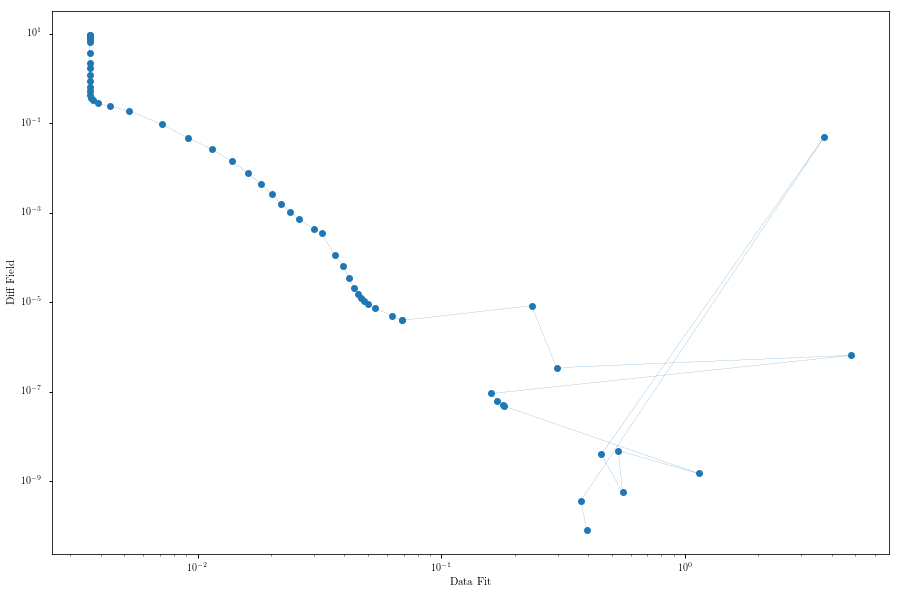

In [20]:
plt.loglog(datafit_values[:,1], dfield_direct[:,1], '--o', linewidth=0.25)
plt.xlabel("Data Fit")
plt.ylabel("Diff Field")

Text(0, 0.5, '$\\kappa$')

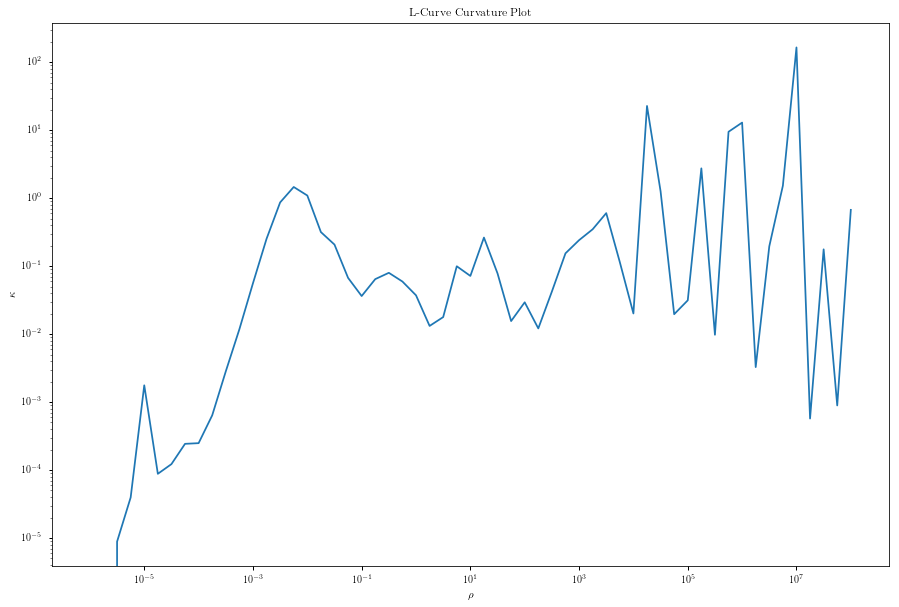

In [21]:
curv_dx = np.gradient(np.log(datafit_values[:,1]))
curv_dy = np.gradient(np.log(dfield_direct[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

## Odd Validation

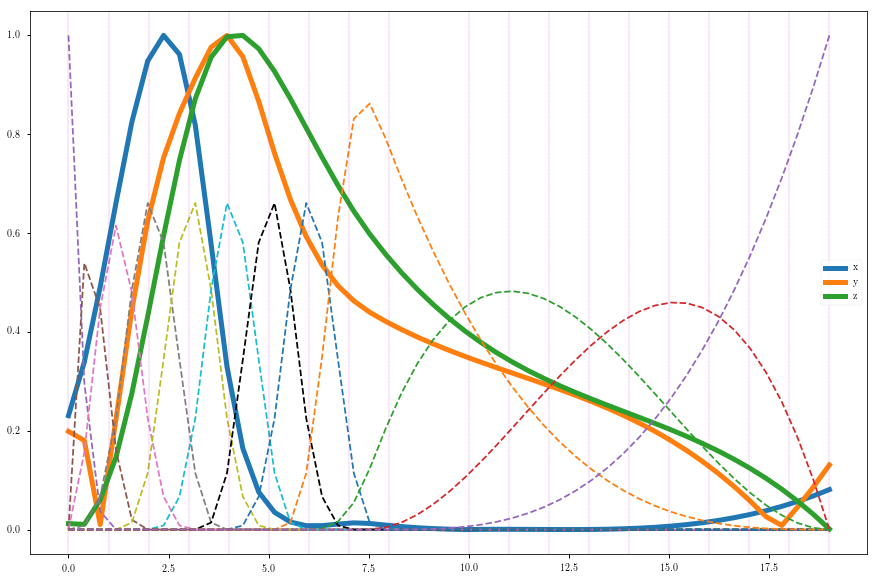

In [22]:
bfn = modeller.ca.Function('basis_fns', [solver.models[0].ts], [solver.models[0].basis])
plt.plot(solver.models[0].observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(solver.models[0].observation_times, bfn(solver.models[0].observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [23]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

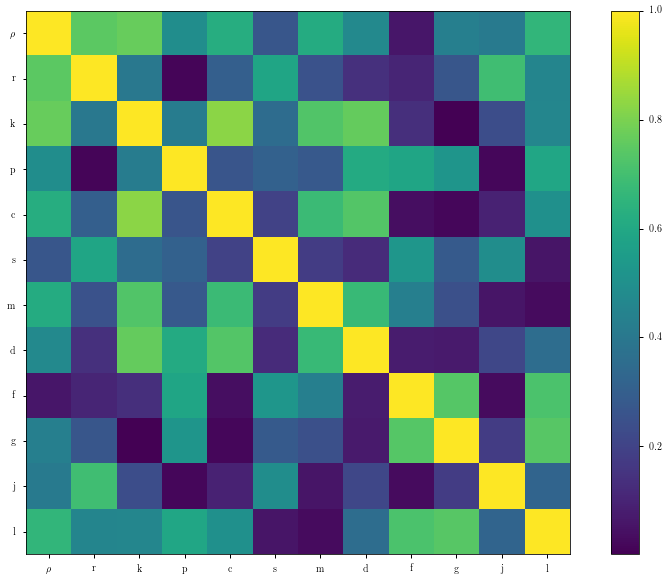

In [24]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

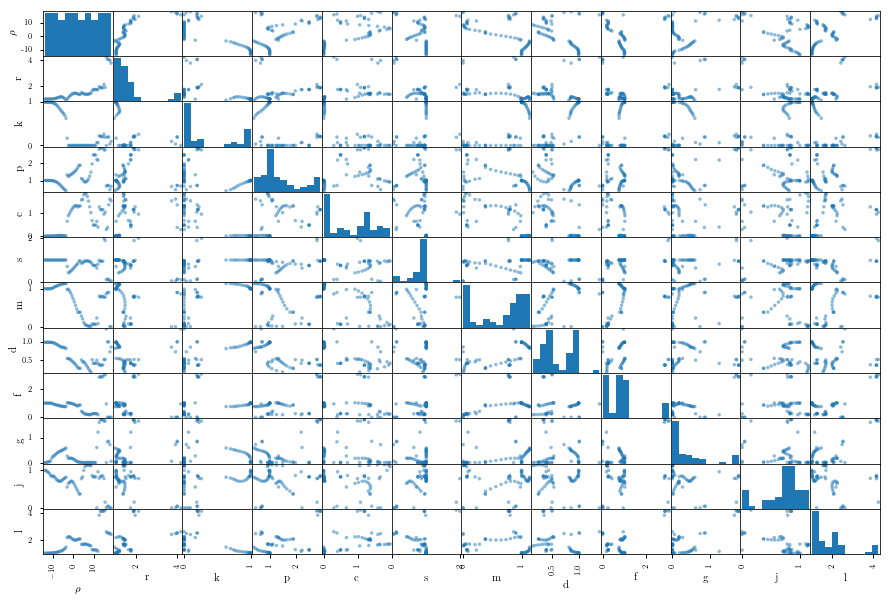

In [25]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

## Smoothing Experiments

In [26]:
from scipy import interpolate

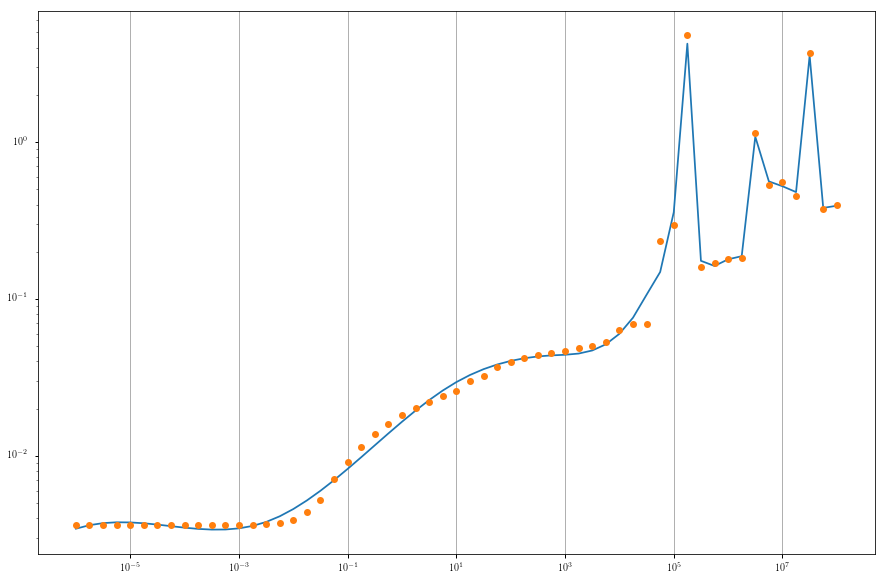

In [27]:
smooth_outer = interpolate.UnivariateSpline(np.log10(rhos), np.log10(datafit_values[:,1]), s=0.14)
souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
plt.loglog(rhos, souter, rhos, datafit_values[:,1], 'o')
plt.gca().xaxis.grid(True)

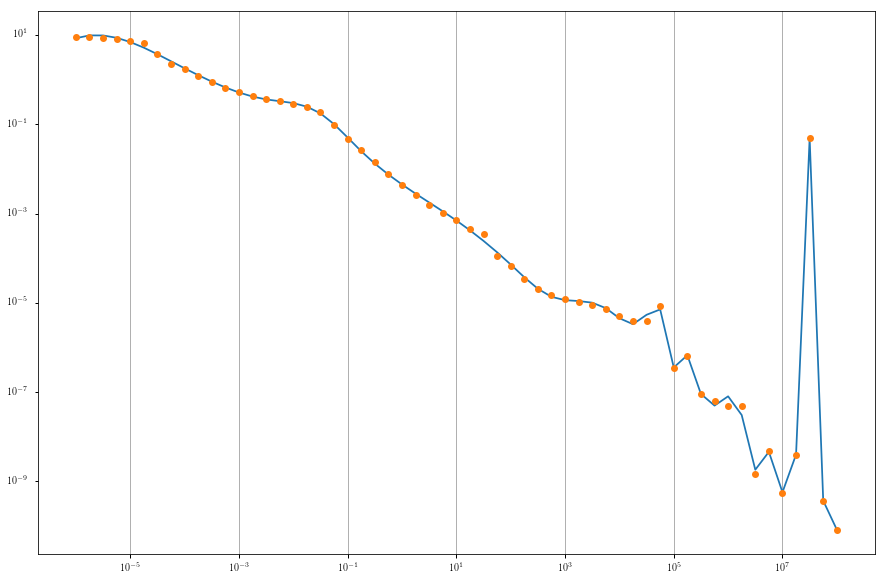

In [28]:
smooth_dfield = interpolate.UnivariateSpline(np.log10(rhos), np.log10(dfield_direct[:,1]), s=0.2)
sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])
plt.loglog(rhos, sfield, rhos, dfield_direct[:,1], 'o')
plt.gca().xaxis.grid(True)

In [29]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)
sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)
plottable_sx = 10**sx
plottable_sy = 10**sy

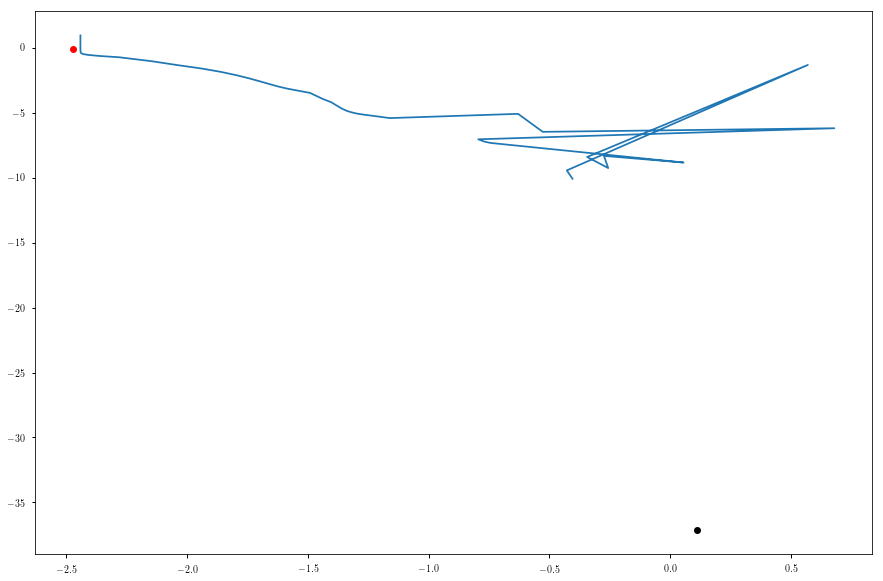

In [30]:
plt.plot(np.log10(datafit_values[:,1]), np.log10(dfield_direct[:,1]))
ix = np.argmin(sx)
iy = np.argmin(sy)
plt.plot(sx[ix], sy[ix], 'ro', sx[iy], sy[iy], 'ko')

Text(0, 0.5, 'Gradient Field Discrepancy')

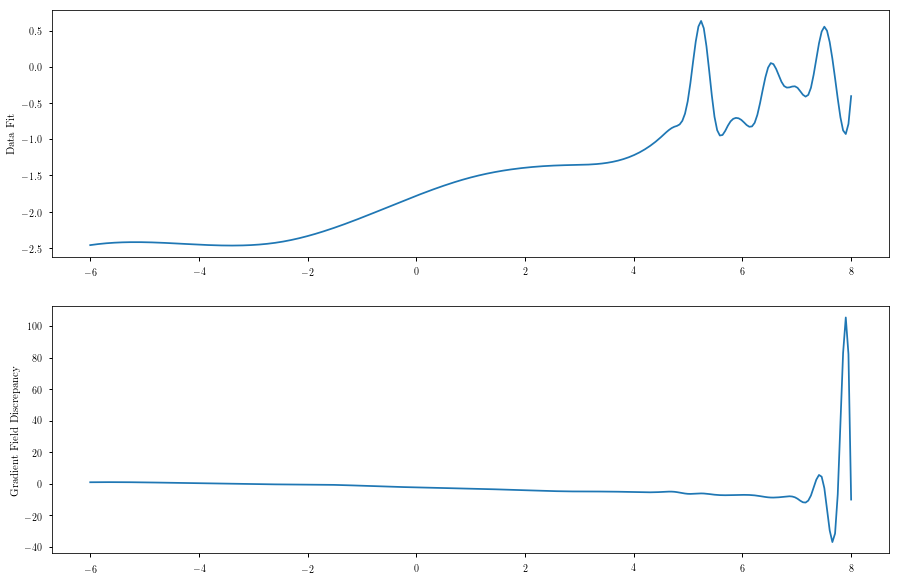

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(rhos_log_finer, sx)
ax2.plot(rhos_log_finer, sy)
ax1.set_ylabel("Data Fit")
ax2.set_ylabel("Gradient Field Discrepancy")

(5.839410021005395e-45, 6.488118067161369e+112)

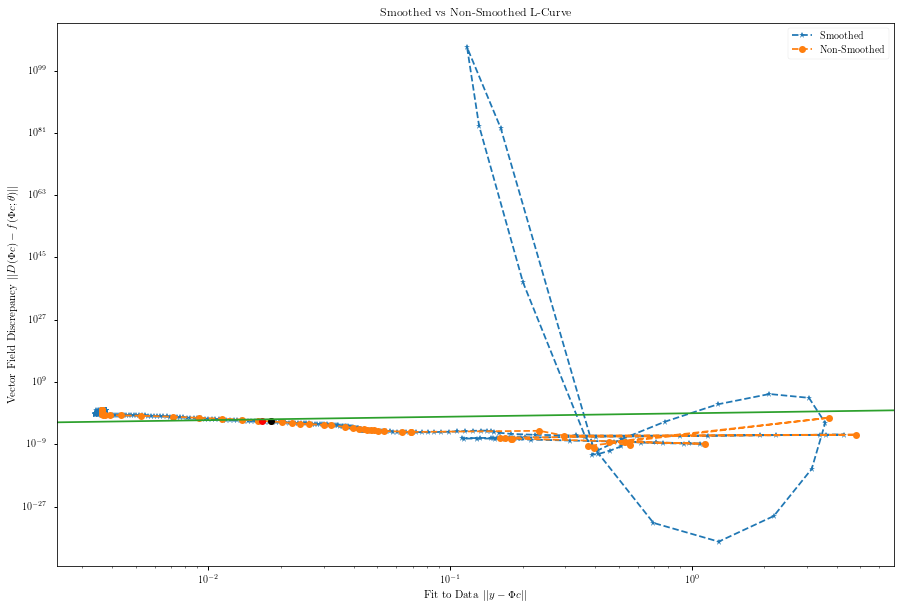

In [32]:
plt.loglog(plottable_sx, plottable_sy, '*--', datafit_values[:,1], dfield_direct[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Fit to Data $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

plt.loglog(plottable_sx[np.argmin(np.abs(rhos_log_finer - 0))],
           plottable_sy[np.argmin(np.abs(rhos_log_finer - 0))],
           'ro',
           datafit_values[np.argmin(np.abs(np.array(rhos) - 1)), 1],
           dfield_direct[np.argmin(np.abs(np.array(rhos) - 1)), 1], 
           'ko')
xlims = plt.xlim()
ylims = plt.ylim()
plt.loglog(np.linspace(10**(-15), 10**(4)), np.linspace(10**(-15), 10**(4)))
plt.xlim(xlims); plt.ylim(ylims)

Text(0, 0.5, '$\\kappa$')

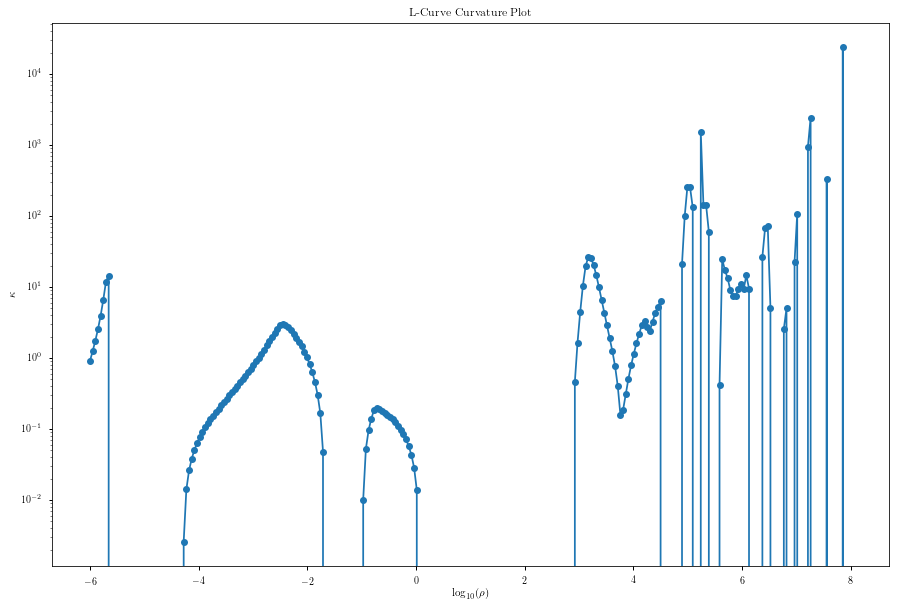

In [33]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.semilogy(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

Text(0, 0.5, '$\\kappa$')

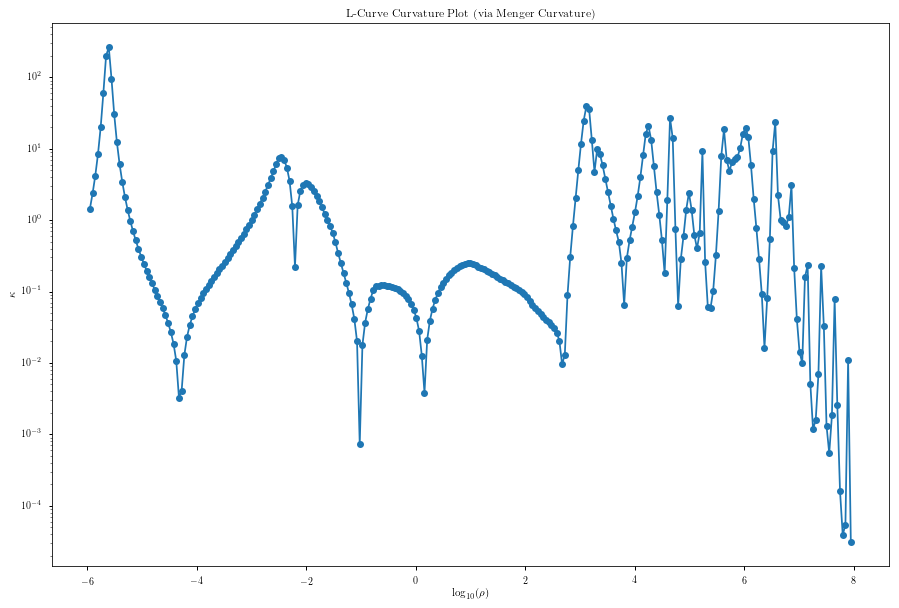

In [34]:
# menger curvature
curvs = []

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.semilogy(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

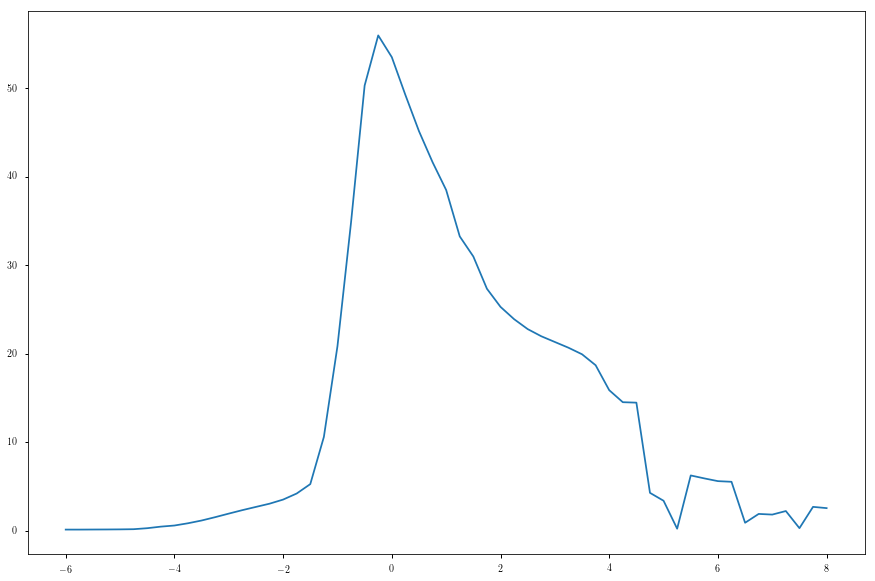

In [35]:
# implement the heuristic measurement
origin  = (0,0)
xy = np.array(list(zip(datafit_values[:,1], dfield_direct[:,1])))
distances = [np.linalg.norm(xyi) for xyi in xy]
plt.plot(np.log10(rhos), [1/d for d in distances])

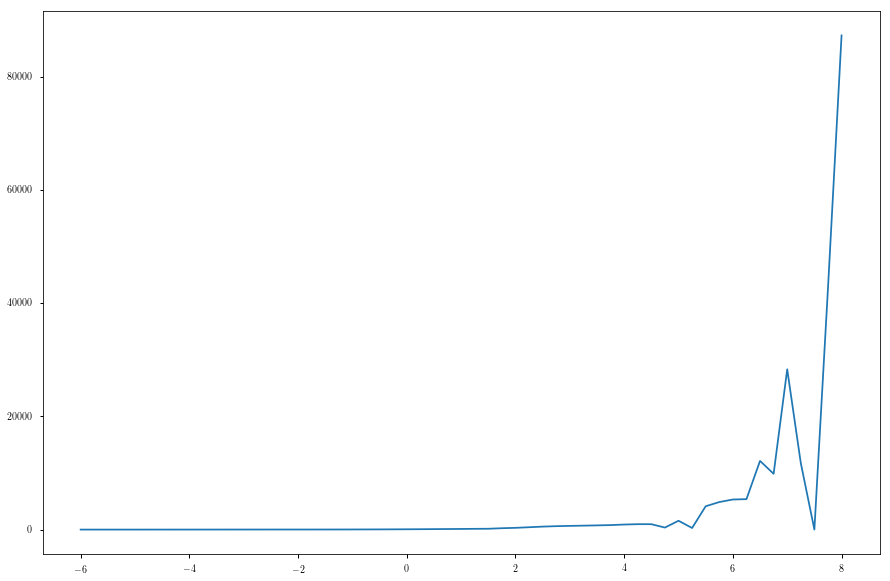

In [36]:
# implement a GM heuristic
gmdistances = [2*np.sqrt(np.prod(xyi)) for xyi in xy]
plt.plot(np.log10(rhos), [1/g for g in gmdistances])

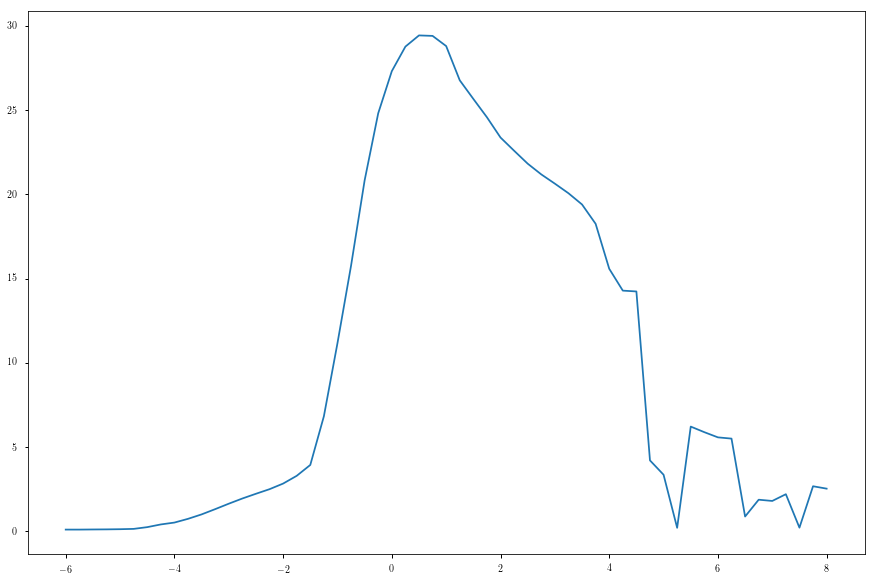

In [37]:
tot_heur = 1/np.sum([gmdistances,distances], axis=0)
plt.plot(np.log10(rhos), tot_heur)

0.06606665178245753 : 0.1019101285228261
0.26337986301286376 : 0.17327184017072775


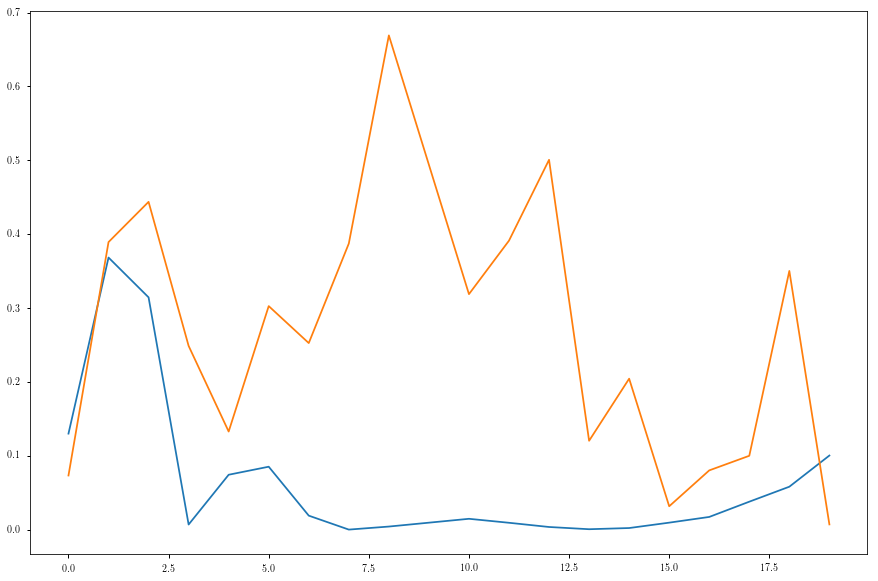

In [38]:
observable_x = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[0]
observable_z = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[2]

x_err = np.abs(observable_x.T - np.array(context.datasets[0]['x'])).reshape(-1,)
z_err = np.abs(observable_z.T - np.array(context.datasets[0]['z'])).reshape(-1,)

t = np.array(context.datasets[0]['t'])

plt.plot(t, x_err, t, z_err)
print(f"{np.mean(x_err)} : {np.std(x_err)}")
print(f"{np.mean(z_err)} : {np.std(z_err)}")


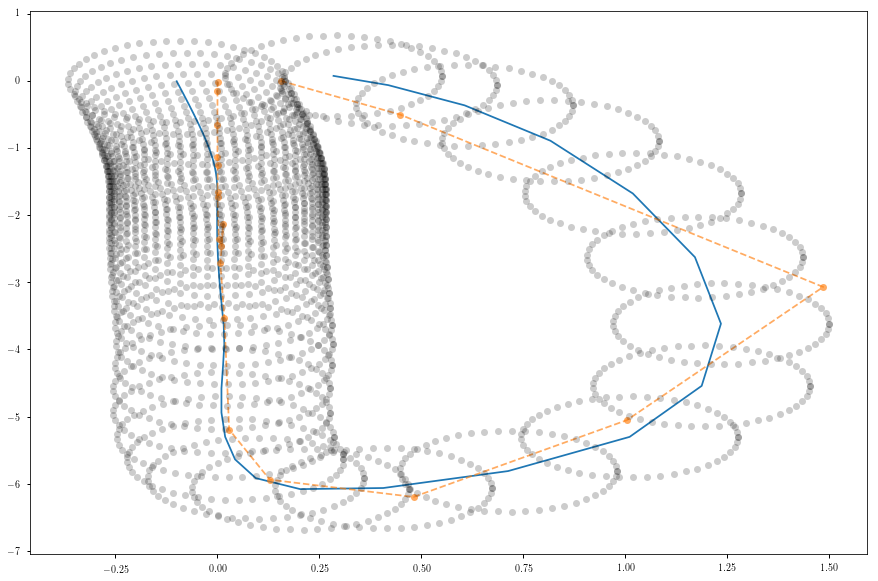

In [39]:
x0, y0 = xs_end[[0,2], :]
xscale = np.mean(x_err) + 1.96*np.std(x_err)
zscale = np.mean(z_err) + 1.96*np.std(z_err)
circle_x, circle_y = [x0 + xscale*np.cos(np.linspace(0, 2*np.pi, 50)), y0 + zscale*np.sin(np.linspace(0, 2*np.pi, 50))]

plt.plot(xs_end[0], xs_end[2])
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.plot(circle_x, circle_y, 'ko', alpha=0.2)
print('')


In [40]:
## Use heuristic to estimate the "ideal" parameter
# maximus = 10**rhos_log_finer[np.argmax(tot_heur)+1]
# print(f"{maximus}\n is the spike")
# closest_rho = rhos[np.argmin(np.abs(rhos-maximus))]
# print(f"{closest_rho}\n is the closest")
closest_rho = rhos[np.argmax(tot_heur)]
print(f"{closest_rho}\n is the closest")

3.1622776601683795
 is the closest


## Analysis

In [41]:
# for each parameter, evaluate local curvature
ps_end = solver.solutions[str(target_rho)][0].x
fisher = []
for p in solver.models[0].ps:
    H,g = fitter.ca.hessian(solver.inner_objectives[0].inner_criterion, p)
    hfn = fitter.ca.Function('hfn', solver.inner_objectives[0].input_list, [H])
    fisher.append(float(hfn(solver.models[0].observation_times,
              *fitter.argsplit(solver.problems[0].cache.results[tokey(target_rho, ps_end)].x, 3),
              *ps_end,
              solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
              len(context.datasets[0]['t']),
              *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
              target_rho)))
print(fisher)

[3.757160725206427, 3.431807639180888, 2.7183994751699228, 1.3534187850681396, 4.123141597456933, 12.864385427525745, 526.937709202057, 6.936649832081034, 158.7081638419923, 188.83812423364031, 3.431807639180888, 6.936649832081035]


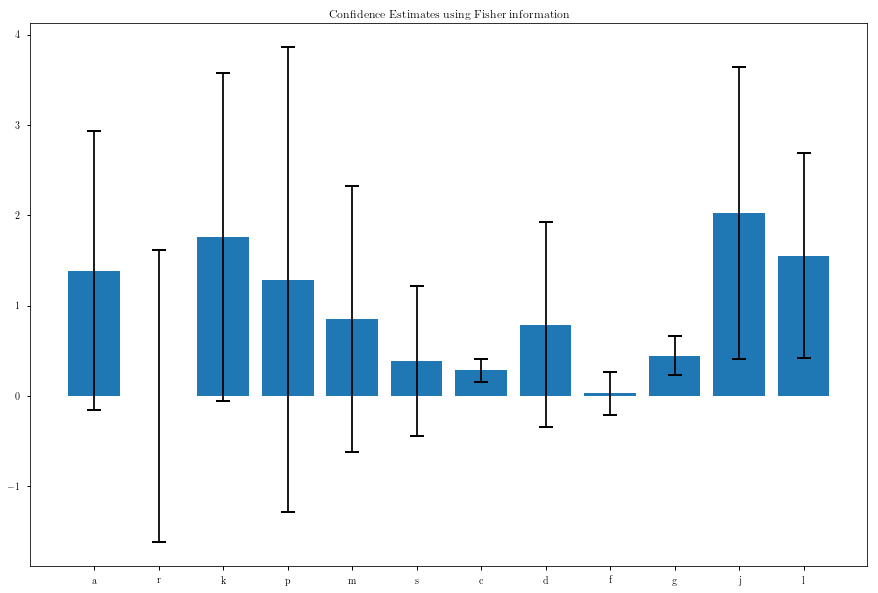

In [42]:
px = range(len(ps_end))
plt.bar(px, ps_end)
plt.errorbar(px, ps_end, yerr=3*np.sqrt(1/np.array(fisher)), 
             capsize=7, markeredgewidth=2, linestyle='None', ecolor='k', color='k')
plt.xticks(px, 'arkpmscdfgjl')
plt.title("Confidence Estimates using Fisher information")
print('')

In [43]:
parameters = solver.solutions[str(target_rho)][0].x
print(-parameters[1]/parameters[0])

-0.0


In [44]:
%%script false

r,a,b,k,p,m,s,c,d,f,g,j,l = solver.solutions[str(target_rho)][0].x
characteristic1 = np.roots([-d, s, 0, -d*c*c*c, 0])
temp_alpha = (s*r*r*r)/(c*c*c*k*k*k+r*r*r) - d*r/k
characteristic2 = np.roots([temp_alpha, p, m*m*temp_alpha])

# these are the values of gamma and xi
print(characteristic1)
print(characteristic2)

eq_values1 = l*characteristic1/(f*characteristic1 - g)
eq_values2 = (j*k*characteristic2 + l*r)/(f*r-g*k)

print(eq_values1)
print(eq_values2)

rk = r/k

def is_stable(point):
    x,y,z = point
    G = f*y-g
    A = r-k*y
    B = -k*x
    C = p/(m**2+x**2) - (2*p*x**2)/(m**2+x**2)**2
    D = (3*s*y**2)/(c**3 + y**3) - d - (3*s*y**5)/(c**3 + y**3)**2
    character = (G<0, (A+D)<0 , A*D-B*C>0)
    if all(character):
        if ((A+D)**2)/4 < (A*D-B*C):
            return "z-xy-focus"
        return "z-xy"
    elif character[0:3:2] == (True, False):
        return "z-saddle"
    elif character == (False, True, True):
        if ((A+D)**2)/4 < (A*D-B*C):
            return "unstable-xy-focus"
        return "unstable-xy"
    elif character[0]:
        if ((A+D)**2)/4 < (A*D-B*C):
            return "z-unstable-focus"
        return "z-unstable"
    else:
        if ((A+D)**2)/4 < (A*D-B*C):
            return "unstable-unstable-focus"
        return "unstable-unstable"

    
stabilities1 = [is_stable([0, ch, eq]) for ch, eq in zip(characteristic1, eq_values1)]
stabilities2 = [is_stable([ch, rk, eq]) for ch, eq in zip(characteristic2, eq_values2)]

print(stabilities1)
print(stabilities2)

plt.plot([0]*len(eq_values1[np.isreal(eq_values1)]), eq_values1[np.isreal(eq_values1)], 'ro')
plt.plot(characteristic2[np.isreal(eq_values2)], eq_values2[np.isreal(eq_values2)], 'ro')
plt.xlabel('x')
plt.ylabel('z')

print(f*r/k-g)

CalledProcessError: Command 'b'\nr,a,b,k,p,m,s,c,d,f,g,j,l = solver.solutions[str(target_rho)][0].x\ncharacteristic1 = np.roots([-d, s, 0, -d*c*c*c, 0])\ntemp_alpha = (s*r*r*r)/(c*c*c*k*k*k+r*r*r) - d*r/k\ncharacteristic2 = np.roots([temp_alpha, p, m*m*temp_alpha])\n\n# these are the values of gamma and xi\nprint(characteristic1)\nprint(characteristic2)\n\neq_values1 = l*characteristic1/(f*characteristic1 - g)\neq_values2 = (j*k*characteristic2 + l*r)/(f*r-g*k)\n\nprint(eq_values1)\nprint(eq_values2)\n\nrk = r/k\n\ndef is_stable(point):\n    x,y,z = point\n    G = f*y-g\n    A = r-k*y\n    B = -k*x\n    C = p/(m**2+x**2) - (2*p*x**2)/(m**2+x**2)**2\n    D = (3*s*y**2)/(c**3 + y**3) - d - (3*s*y**5)/(c**3 + y**3)**2\n    character = (G<0, (A+D)<0 , A*D-B*C>0)\n    if all(character):\n        if ((A+D)**2)/4 < (A*D-B*C):\n            return "z-xy-focus"\n        return "z-xy"\n    elif character[0:3:2] == (True, False):\n        return "z-saddle"\n    elif character == (False, True, True):\n        if ((A+D)**2)/4 < (A*D-B*C):\n            return "unstable-xy-focus"\n        return "unstable-xy"\n    elif character[0]:\n        if ((A+D)**2)/4 < (A*D-B*C):\n            return "z-unstable-focus"\n        return "z-unstable"\n    else:\n        if ((A+D)**2)/4 < (A*D-B*C):\n            return "unstable-unstable-focus"\n        return "unstable-unstable"\n\n    \nstabilities1 = [is_stable([0, ch, eq]) for ch, eq in zip(characteristic1, eq_values1)]\nstabilities2 = [is_stable([ch, rk, eq]) for ch, eq in zip(characteristic2, eq_values2)]\n\nprint(stabilities1)\nprint(stabilities2)\n\nplt.plot([0]*len(eq_values1[np.isreal(eq_values1)]), eq_values1[np.isreal(eq_values1)], \'ro\')\nplt.plot(characteristic2[np.isreal(eq_values2)], eq_values2[np.isreal(eq_values2)], \'ro\')\nplt.xlabel(\'x\')\nplt.ylabel(\'z\')\n\nprint(f*r/k-g)\n'' returned non-zero exit status 1.

# Utilities

In [ ]:
solver.solutions

In [ ]:
rhos